In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

In [2]:
rotations = np.array([(np.pi/2 + n*np.pi/8)%(2*np.pi) for n in range(16)])
cardinals_map = dict(zip(utils.CARDINALS, rotations))

df1 = pd.read_csv("weatherAUS.csv.zip")
df1 = utils.process_data(df1, cardinals_map)
df2 = pd.read_csv("weatherAUS_second_source.csv.zip")  # from https://rdrr.io/cran/rattle.data/man/weatherAUS.html
df2 = utils.process_data(df2, cardinals_map)
df = pd.concat([df1, df2])
del df1; del df2; gc.collect()
df.drop_duplicates(subset=["Date", "Location"], keep="first", inplace=True)
df.sort_values(by=["Date", "Location"], inplace=True, ignore_index=True)
df.drop(columns=["RainToday"], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["RainTomorrow"]), df["RainTomorrow"], test_size=0.25, shuffle=False
)

In [3]:
month = (X_train["Date"].dt.month + X_train["Date"].dt.day/30)
month_x = np.cos(month*np.pi/6)
month_y = np.sin(month*np.pi/6)

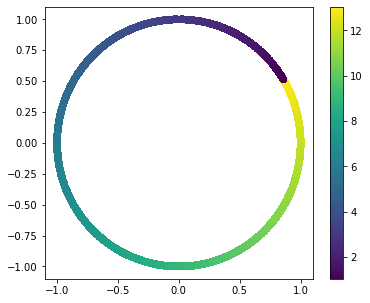

In [4]:
plt.figure(figsize=(6, 5))
plt.scatter(month_x, month_y, c=month)
plt.colorbar()

## Sunshine predictor

In [5]:
X_train.head(2*365)['Location'].unique()

array(['Canberra', 'Sydney', 'Adelaide', 'Brisbane', 'Darwin', 'Hobart',
       'Melbourne', 'Perth'], dtype=object)

In [6]:
n_samples = 2*365
lat_scale = 50
lng_scale = 200
temp_scale = 50
sunshine_predictors = X_train[["Location", "lat", "lng", "Month_x_comp", "Month_y_comp", "Temp9am"]].copy()
sunshine_predictors.update(sunshine_predictors.groupby("Location").ffill())  # to help include more locations without look-ahead
sunshine_predictors["lat"] /= lat_scale
sunshine_predictors["lng"] /= lng_scale
sunshine_predictors["Temp9am"] /= temp_scale

sunshine_model = Ridge(alpha=0.1).fit(
    sunshine_predictors.drop(columns=["Location"]).head(n_samples),
    X_train.groupby("Location")['Sunshine'].ffill().head(n_samples)
)

print("Model:")
print(f"S_pred = {round(sunshine_model.coef_[0]/lat_scale, 3)}LAT"
      f" + {round(sunshine_model.coef_[1]/lng_scale, 3)}LNG"
      f" + {round(sunshine_model.coef_[2], 3)}Month_x"
      f" + {round(sunshine_model.coef_[3], 3)}Month_y"
      f" + {round(sunshine_model.coef_[4]/temp_scale, 3)}Temp9am"
      f" + {round(sunshine_model.intercept_, 3)}")

X_train['sun_pred'] = (sunshine_model.intercept_
                       + sunshine_model.coef_[0]*X_train["lat"]/lat_scale
                       + sunshine_model.coef_[1]*X_train["lng"]/lng_scale
                       + sunshine_model.coef_[2]*X_train["Month_x_comp"]
                       + sunshine_model.coef_[3]*X_train["Month_y_comp"]
                       + sunshine_model.coef_[4]*X_train["Temp9am"]/temp_scale)

Model:
S_pred = 0.273LAT + 0.007LNG + 1.689Month_x + 1.361Month_y + -0.164Temp9am + 18.026


<AxesSubplot:>

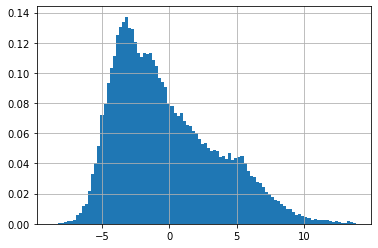

In [7]:
(X_train.set_index('Date')['sun_pred'] - X_train.set_index('Date')['Sunshine']).hist(bins=100, density=True)

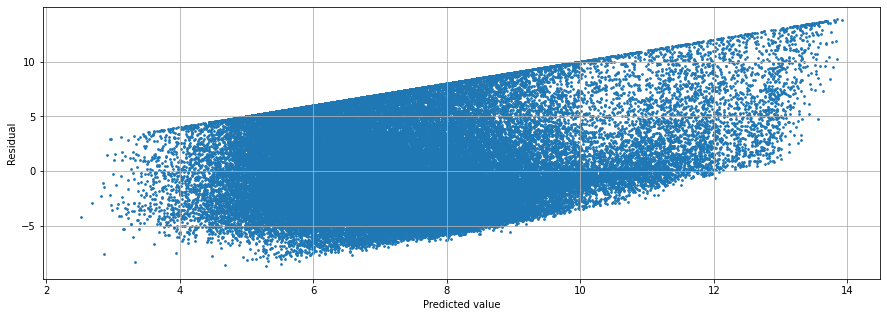

In [8]:
plt.figure(figsize=(15, 5))
plt.scatter(X_train['sun_pred'], X_train['sun_pred'] - X_train['Sunshine'], s=3)
plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.grid()

<AxesSubplot:xlabel='Date'>

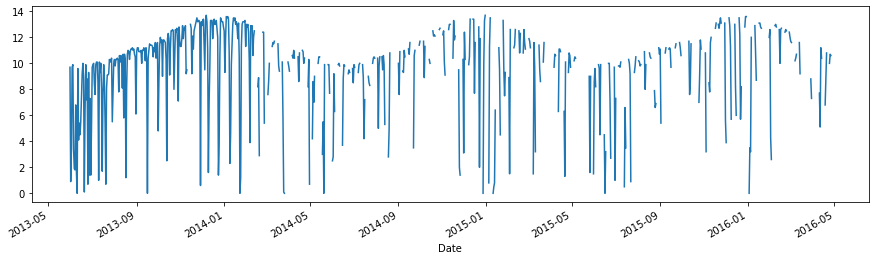

In [9]:
X_train.query("Location=='Moree'").set_index("Date")['Sunshine'][-1600:].plot(figsize=(15, 4))

<AxesSubplot:xlabel='Date'>

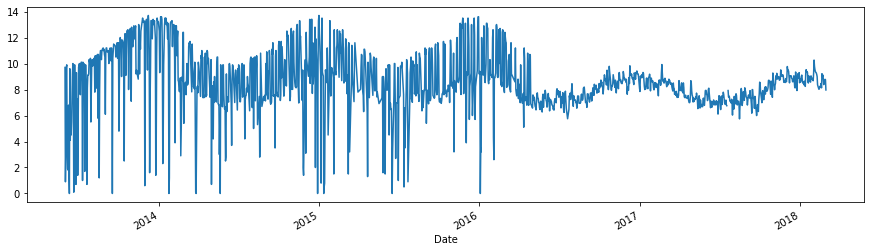

In [10]:
X_train["Sunshine_filled"] = X_train["Sunshine"].fillna(X_train["sun_pred"])
X_train.query("Location=='Moree'").set_index("Date")['Sunshine_filled'][-1600:].plot(figsize=(15, 4))

## Evaporation predictor

In [11]:
n_samples = 2*365
lat_scale = 50
lng_scale = 200
temp_scale = 50
evaporation_predictors = X_train[["Location", "lat", "lng", "Month_x_comp", "Month_y_comp", "Temp9am"]].copy()
evaporation_predictors.update(evaporation_predictors.groupby("Location").ffill())  # to help include more locations without look-ahead
evaporation_predictors["lat"] /= lat_scale
evaporation_predictors["lng"] /= lng_scale
evaporation_predictors["Temp9am"] /= temp_scale

evaporation_model = Ridge(alpha=.1).fit(
    evaporation_predictors.drop(columns=["Location"]).head(n_samples),
    X_train.groupby("Location")['Evaporation'].ffill().head(n_samples)
)

print("Model:")
print(f"E_pred = {round(evaporation_model.coef_[0]/lat_scale, 3)}LAT"
      f" + {round(evaporation_model.coef_[1]/lng_scale, 3)}LNG"
      f" + {round(evaporation_model.coef_[2], 3)}Month_x"
      f" + {round(evaporation_model.coef_[3], 3)}Month_y"
      f" + {round(evaporation_model.coef_[4]/temp_scale, 3)}Temp9am"
      f" + {round(evaporation_model.intercept_, 3)}")

X_train['evap_pred'] = (evaporation_model.intercept_
                       + evaporation_model.coef_[0]*X_train["lat"]/lat_scale
                       + evaporation_model.coef_[1]*X_train["lng"]/lng_scale
                       + evaporation_model.coef_[2]*X_train["Month_x_comp"]
                       + evaporation_model.coef_[3]*X_train["Month_y_comp"]
                       + evaporation_model.coef_[4]*X_train["Temp9am"]/temp_scale)

Model:
E_pred = 0.137LAT + 0.006LNG + 1.746Month_x + 1.089Month_y + 0.069Temp9am + 7.334


<AxesSubplot:>

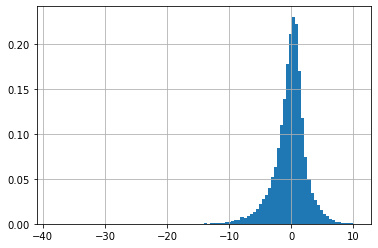

In [12]:
(X_train.set_index('Date')['evap_pred'] - X_train.set_index('Date')['Evaporation']).hist(bins=100, density=True)

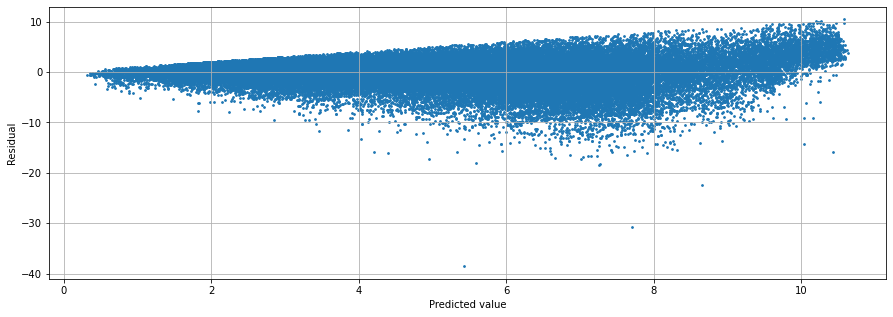

In [13]:
plt.figure(figsize=(15, 5))
plt.scatter(X_train['evap_pred'], X_train['evap_pred'] - X_train['Evaporation'], s=3)
plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.grid()

<AxesSubplot:xlabel='Date'>

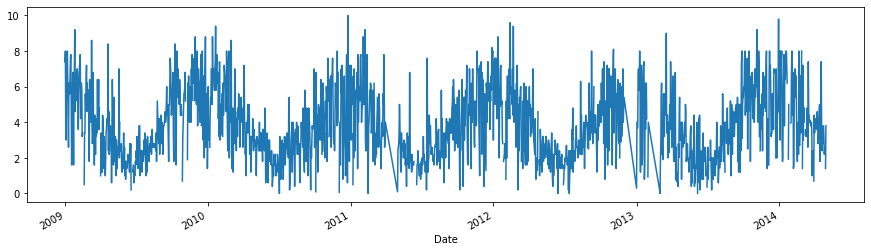

In [14]:
X_train.query("Location=='CoffsHarbour'").set_index("Date")['Evaporation'][:].plot(figsize=(15, 4))

<AxesSubplot:xlabel='Date'>

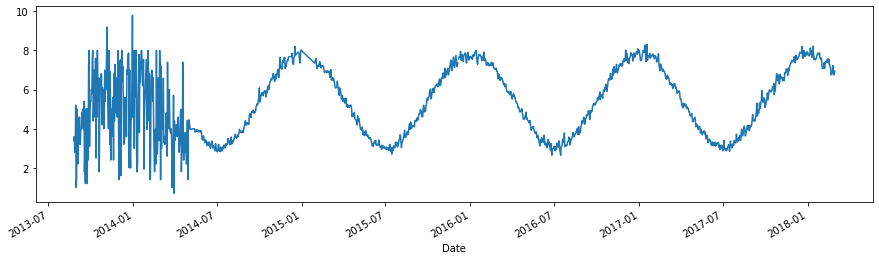

In [15]:
X_train["Evap_filled"] = X_train["Evaporation"].fillna(X_train["evap_pred"])
X_train.query("Location=='CoffsHarbour'").set_index("Date")['Evap_filled'][-1600:].plot(figsize=(15, 4))